In [40]:

import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUS

# Loading the images and Masks

In [41]:
def load_images_and_masks(image_dir, target_size=(224, 224)):
    images = []
    masks = []
    for label_folder in ['benign', 'malignant', 'normal']:
        folder_path = os.path.join(image_dir, label_folder)
        for img_name in os.listdir(folder_path):
            if '_mask' in img_name:
                continue  

            
            img_path = os.path.join(folder_path, img_name)
            mask_path = img_path.replace('.png', '_mask.png')
            image = img_to_array(load_img(img_path, target_size=target_size, color_mode='grayscale'))
            mask = img_to_array(load_img(mask_path, target_size=target_size, color_mode='grayscale'))

            images.append(image)
            masks.append(mask)

    images = np.array(images) / 255.0
    masks = np.array(masks) / 255.0 

    return images, masks


In [42]:
image_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
X, y = load_images_and_masks(image_dir)
print(f"Loaded {len(X)} images and {len(y)} masks.")

Loaded 780 images and 780 masks.


# Data Exploratory

In [43]:
from matplotlib import pyplot as plot

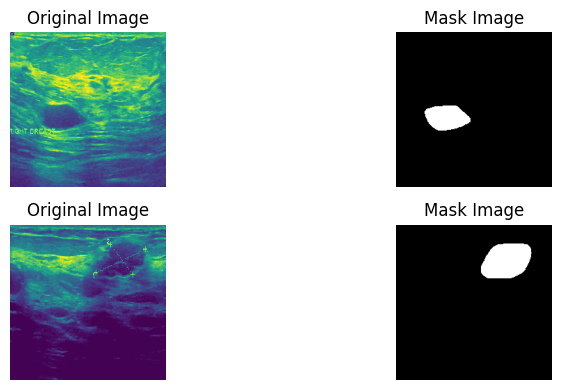

In [56]:
import matplotlib.pyplot as plt


def display_images_and_masks(images, masks, num_samples=5):
    plt.figure(figsize=(10, num_samples * 2))

    for i in range(num_samples):
    
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(images[i])
        plt.title("Original Image")
        plt.axis('off')

       
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Mask Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_images_and_masks(X, y, num_samples=2)


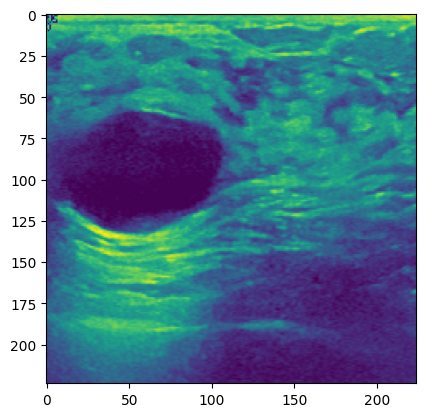

In [61]:
plot.imshow(X[10])

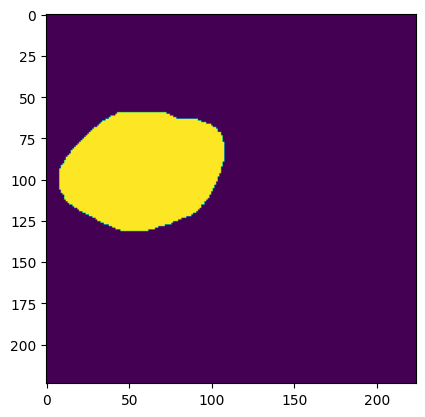

In [62]:
plot.imshow(y[10])

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
xtr,xte,ytr,yte = train_test_split(X,y,test_size=0.2)

# Dice Matric

In [48]:
def dice_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

# Unet Training

In [51]:
import tensorflow as tf
from tensorflow import keras

In [52]:
inputs = keras.layers.Input((224,224,1))



conv1 = keras.layers.Conv2D(32,2,padding='same',activation='relu')(inputs)
conv11 = keras.layers.Conv2D(32,2,padding='same',activation='relu')(conv1)
pool1 = keras.layers.MaxPool2D((2,2))(conv11)


conv2 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(pool1)
conv21 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(conv2)
pool2 = keras.layers.MaxPool2D((2,2))(conv21)



conv3 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(pool2)
conv31 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(conv3)
pool3 = keras.layers.MaxPool2D((2,2))(conv31)

conv4 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(pool3)
conv41 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(conv4)
pool4 = keras.layers.MaxPool2D((2,2))(conv41)


upsample2 = keras.layers.UpSampling2D((2,2))(pool4)

uconv2 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(upsample2)
merge2 = keras.layers.Concatenate()([conv41,uconv2])
uconv21 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(merge2)

upsample3 = keras.layers.UpSampling2D((2,2))(uconv21)

uconv3 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(upsample3)
merge3 = keras.layers.Concatenate()([conv31,uconv3])
uconv31 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(merge3)

upsample4 = keras.layers.UpSampling2D((2,2))(uconv31)

uconv4=  keras.layers.Conv2D(64,3,padding='same',activation='relu')(upsample4)
merge4 = keras.layers.Concatenate()([conv21,uconv4])
uconv41 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(merge4)

upsample5 = keras.layers.UpSampling2D((2,2))(uconv41)

uconv5=  keras.layers.Conv2D(32,3,padding='same',activation='relu')(upsample5)
merge5 = keras.layers.Concatenate()([conv11,uconv5])
uconv51 =  keras.layers.Conv2D(32,3,padding='same',activation='relu')(merge5)


output =  keras.layers.Conv2D(1,1,padding='same',activation='sigmoid')(uconv51)

unet = keras.models.Model(inputs=inputs,outputs=output)
unet.compile(
    optimizer = 'adam',
    metrics = [dice_metric],
    loss='binary_focal_crossentropy'
)
unet.fit(xtr,ytr,epochs=10,validation_data=(xte,yte))

Epoch 1/10


I0000 00:00:1731001532.177347      81 service.cc:145] XLA service 0x795ecc003080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731001532.177409      81 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731001532.177414      81 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731001563.449006      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - dice_metric: 0.1305 - loss: 0.1321 - val_dice_metric: 0.1142 - val_loss: 0.0696
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - dice_metric: 0.1309 - loss: 0.0758 - val_dice_metric: 0.1115 - val_loss: 0.0656
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - dice_metric: 0.1286 - loss: 0.0730 - val_dice_metric: 0.1132 - val_loss: 0.0641
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - dice_metric: 0.1371 - loss: 0.0714 - val_dice_metric: 0.1321 - val_loss: 0.0636
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - dice_metric: 0.1635 - loss: 0.0657 - val_dice_metric: 0.1453 - val_loss: 0.0545
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 374ms/step - dice_metric: 0.1715 - loss: 0.0623 - val_dice_metric: 0.1579 - val_loss: 0.0574
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 376ms/step - dice_metric: 0.1819 - loss: 0.0650 - val_dice_metric: 0.1549 - val_loss: 0.0533
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - dice_metric: 0.1854 -

In [53]:
unet.evaluate(xte,yte)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - dice_metric: 0.1543 - loss: 0.0487


[0.05025428533554077, 0.1588590443134308]

# Prediciton

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


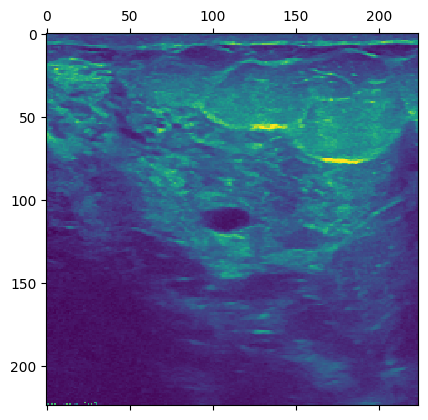

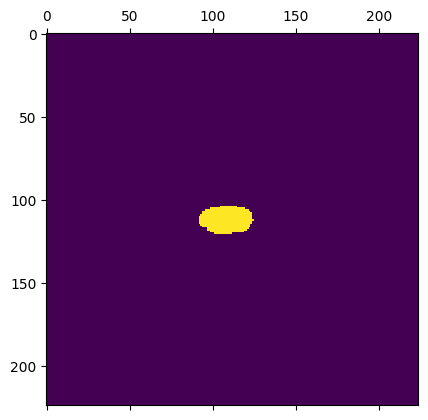

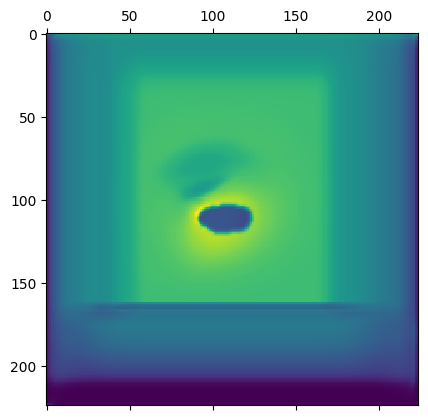

In [57]:
 def plot_test(index,categorical=False):
  plot.matshow(xte[index])
  yp = unet.predict(yte[index].reshape(1,224,224))
  plot.matshow(yte[index])
  plot.matshow(yp.reshape(224,224))
     
plot_test(80)